In [37]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset


from captum.attr import IntegratedGradients, NoiseTunnel, GradientShap, Occlusion, visualization as viz

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from CustomCNN import CustomCNN

In [38]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
# Defined dataset
dataset_type = 'harder'

# Instantiate the model
chanels = 32
kernel_size = 3
model = CustomCNN(chanels, kernel_size)

# Load the weights
model.load_state_dict(torch.load(f"./Models/custom_cnn_dataset_{dataset_type}.pth"))
model.eval()  # Set the model to evaluation mode

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

In [40]:
""" data_easy = torch.load('./data/CustomDataset/easier.pth')
data_harder = torch.load('./data/CustomDataset/harder.pth')
data_vary_disk = torch.load('./data/CustomDataset/vary_disk.pth')

images = torch.cat((data_easy['images'],
                    data_harder['images'],
                    data_vary_disk['images']))

images = images.float()
labels = torch.cat((data_easy['labels'],
                    data_harder['labels'],
                    data_vary_disk['labels'])) """
data = torch.load(f'./data/CustomDataset/{dataset_type}.pth')
images = data['images'].float()
labels = data['labels']

" data = torch.load(f'./data/CustomDataset/{dataset_type}.pth')\nimages = data['images'].float()\nlabels = data['labels'] "

In [41]:
# Create dataset
dataset = TensorDataset(images.unsqueeze(1), labels)  # Add channel dimension

# Split dataset: 80% for training and 20% for validation/testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [42]:
# Pick two images for each digit
selected_images = {i: [] for i in range(2)}
selected_labels = {i: [] for i in range(2)}

for image, label in test_dataset:
    if len(selected_images[label.item()]) < 10:
        selected_images[label.item()].append(image)
        selected_labels[label.item()].append(label)

    # Break if we have collected 2 images for each digit
    if all(len(images) == 10 for images in selected_images.values()):
        break

# Verification
for label, images in selected_images.items():
    print(f"For class {label}, selected {len(images)} images.")

For class 0, selected 10 images.
For class 1, selected 10 images.


In [43]:
# To store results for all images
results = []

# Iterate over labels and their corresponding images
for label, images in selected_images.items():
    for idx, image in enumerate(images):
        # Add batch dimension and run the model
        with torch.no_grad():
            image = image.unsqueeze(0)  # Add batch dimension
            output = model(image)
            predicted_label = torch.argmax(output).item()
            probabilities = F.softmax(output, dim=1)  # Apply softmax to get the probabilities
            prediction_score = probabilities[0][predicted_label].item()  # Confidence score for the predicted label
        
        # Store the results
        result = {
            "True Label": label,
            "Predicted Label": predicted_label,
            "Confidence Score": prediction_score,
            "Probability Distribution": probabilities[0].tolist()
        }
        results.append(result)

# Displaying the results
for res in results:
    print(f"True Label: {res['True Label']}")
    print(f"Predicted Label: {res['Predicted Label']}")
    print(f"Confidence Score for the Predicted Label: {res['Confidence Score']:.4f}")
    print(f"Probability Distribution over Classes: {res['Probability Distribution']}")
    print("="*50)

True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [0.9999513626098633, 4.8651167162461206e-05]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9999
Probability Distribution over Classes: [0.9998596906661987, 0.0001403173228027299]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9998
Probability Distribution over Classes: [0.9998435974121094, 0.00015638071636203676]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9999
Probability Distribution over Classes: [0.9998575448989868, 0.0001424730144208297]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9999
Probability Distribution over Classes: [0.9999343156814575, 6.565137300640345e-05]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [0.9999889135360718, 1.1071996596001554e-05]
True La

In [44]:
integrated_gradients = IntegratedGradients(model)

# Store the attributions for each image
attributions_list = []

# Iterate over images and results
for (label, images), res in zip(selected_images.items(), results):
    for idx, image in enumerate(images):
        predicted_label = res["Predicted Label"]  # Retrieve the predicted label from results
        transformed_img = image.unsqueeze(0)  # Add batch dimension and send to device

        # Compute the attributions using Integrated Gradients
        attributions_ig = integrated_gradients.attribute(transformed_img, target=predicted_label, n_steps=20)
        attributions_list.append(attributions_ig)

/tmp/ipykernel_15275/3383993204.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3383993204.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3383993204.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/33839932

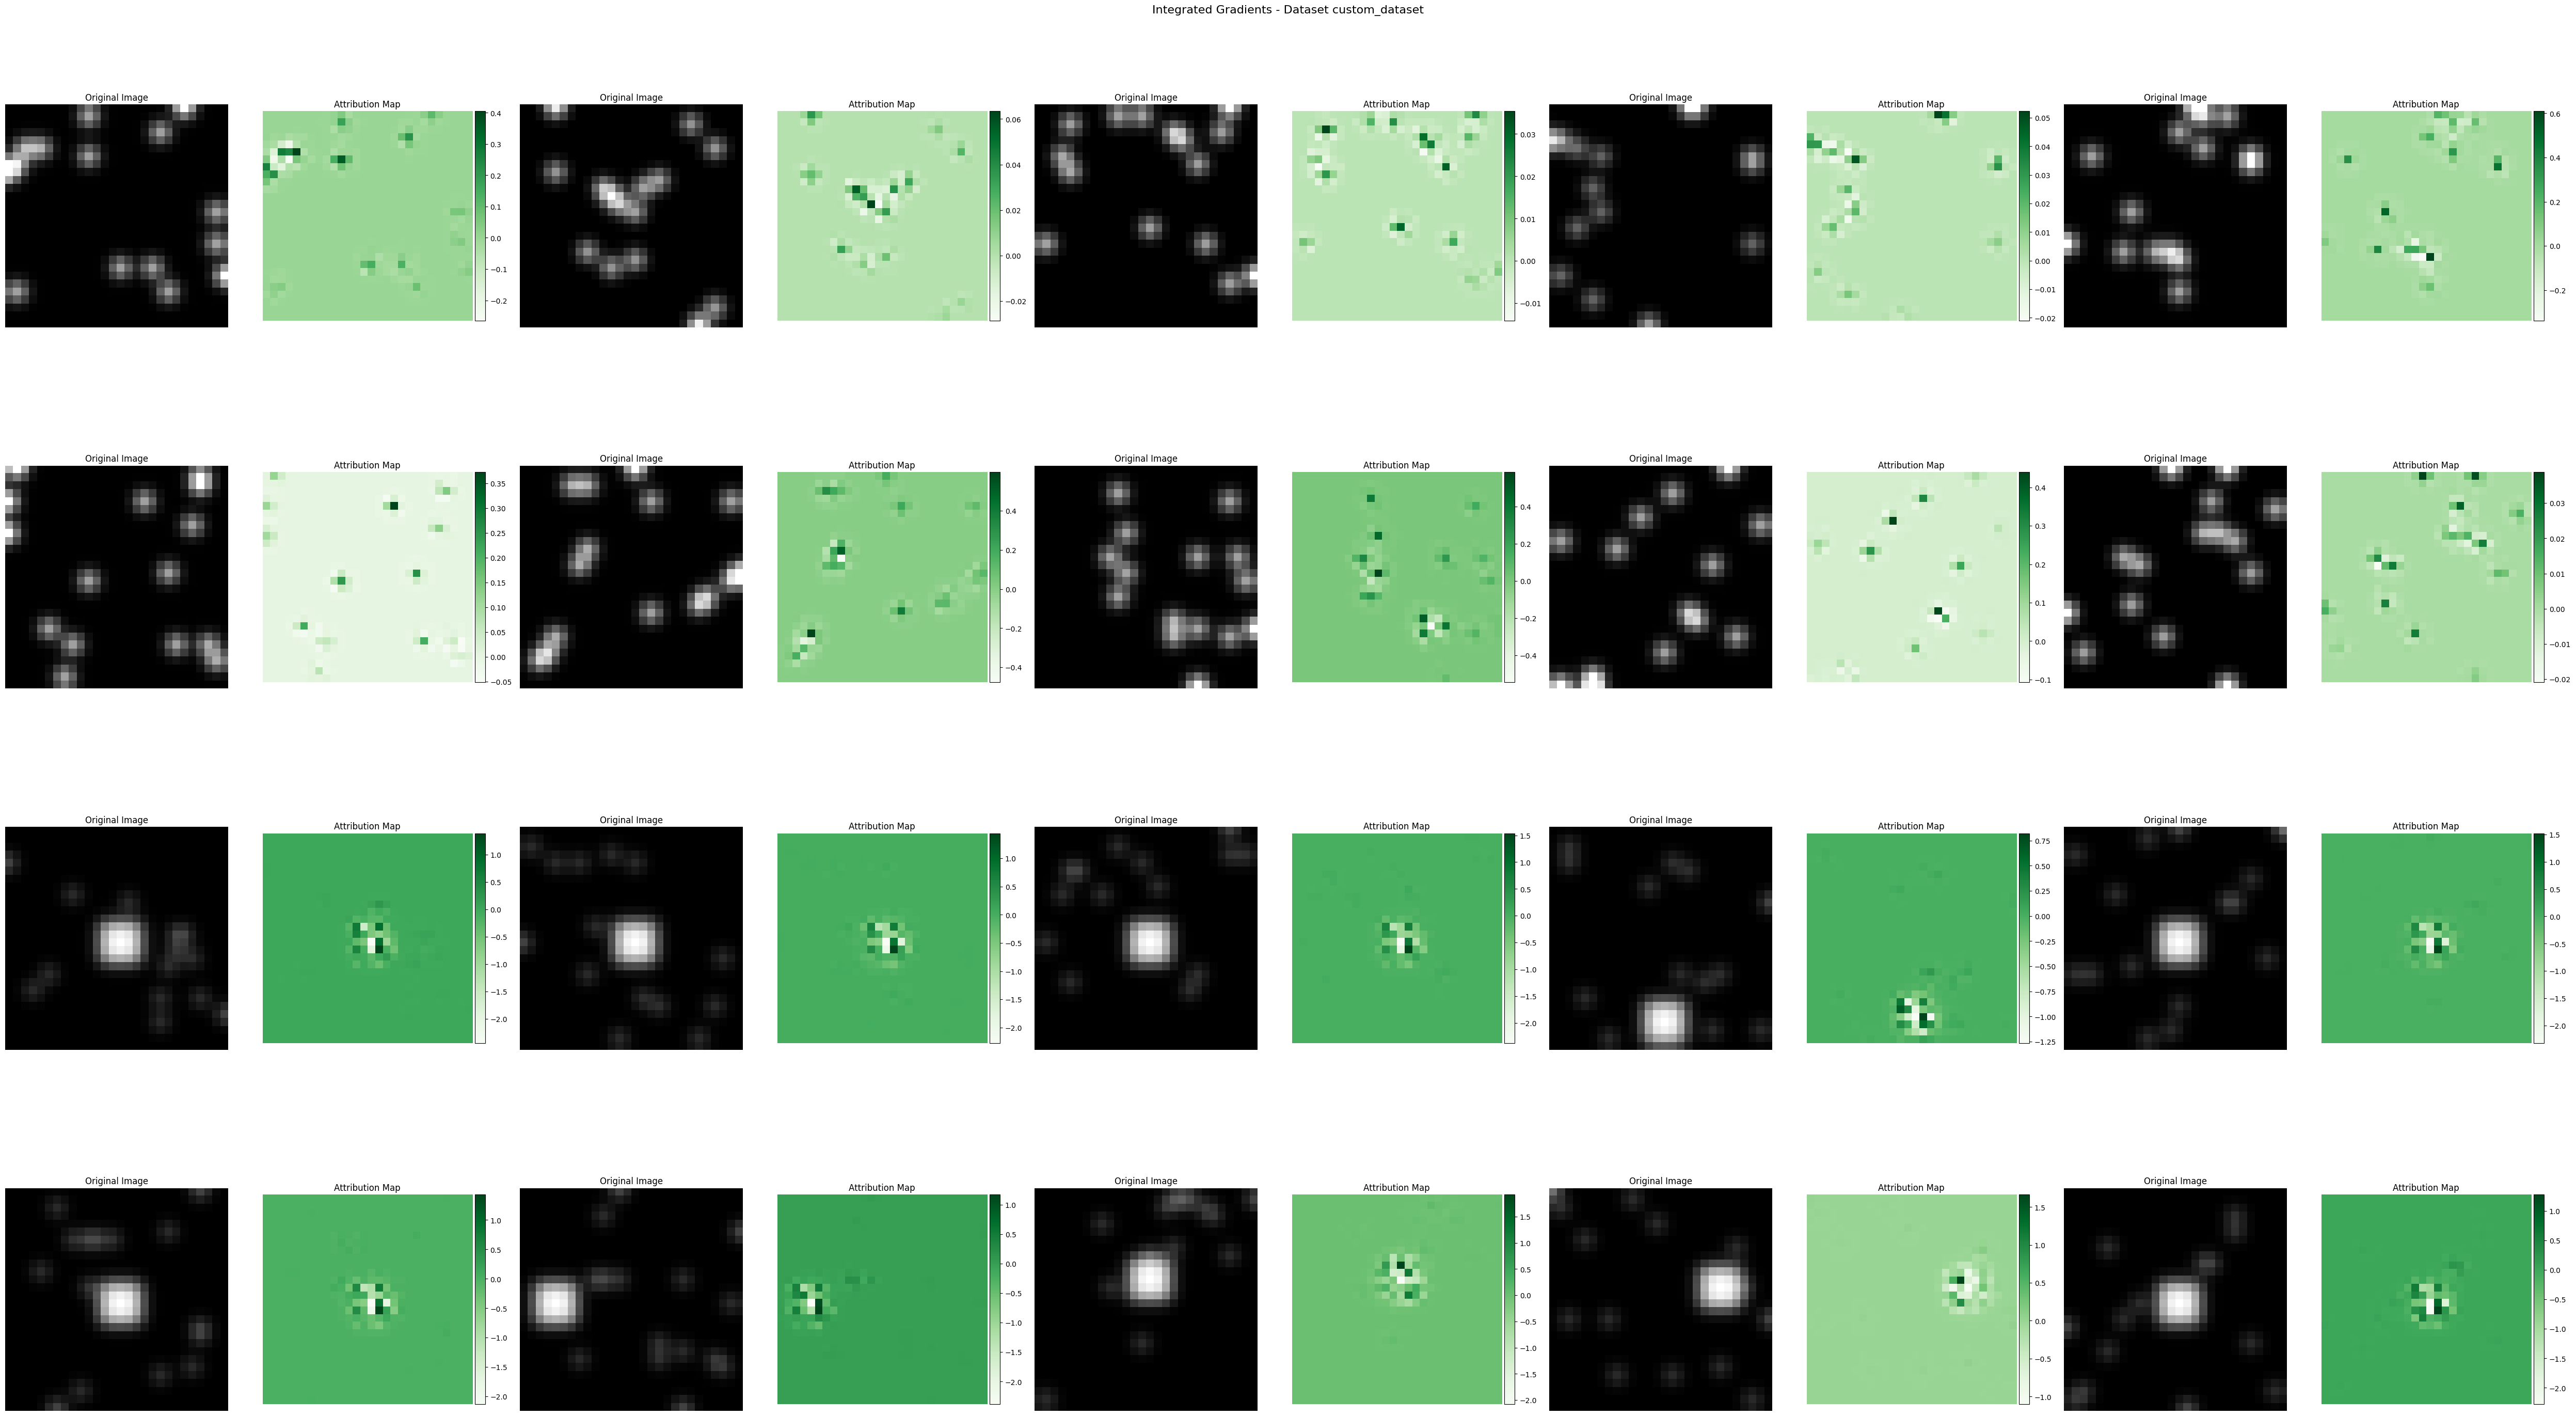

In [45]:
# Create a flat list of images to match the order of attributions
selected_images_list = [img for _, imgs in selected_images.items() for img in imgs]

# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30)) # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Integrated Gradients - Dataset {dataset_type}', fontsize=16)

# Iterate over the attributions and corresponding images
for idx, (attributions, image) in enumerate(zip(attributions_list, selected_images_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side
    
    attr_reshaped = attributions.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

/tmp/ipykernel_15275/3715408033.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/noise_tunnel_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3715408033.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/noise_tunnel_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3715408033.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/noise_tunnel_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3715408033.py:41: MatplotlibDepr

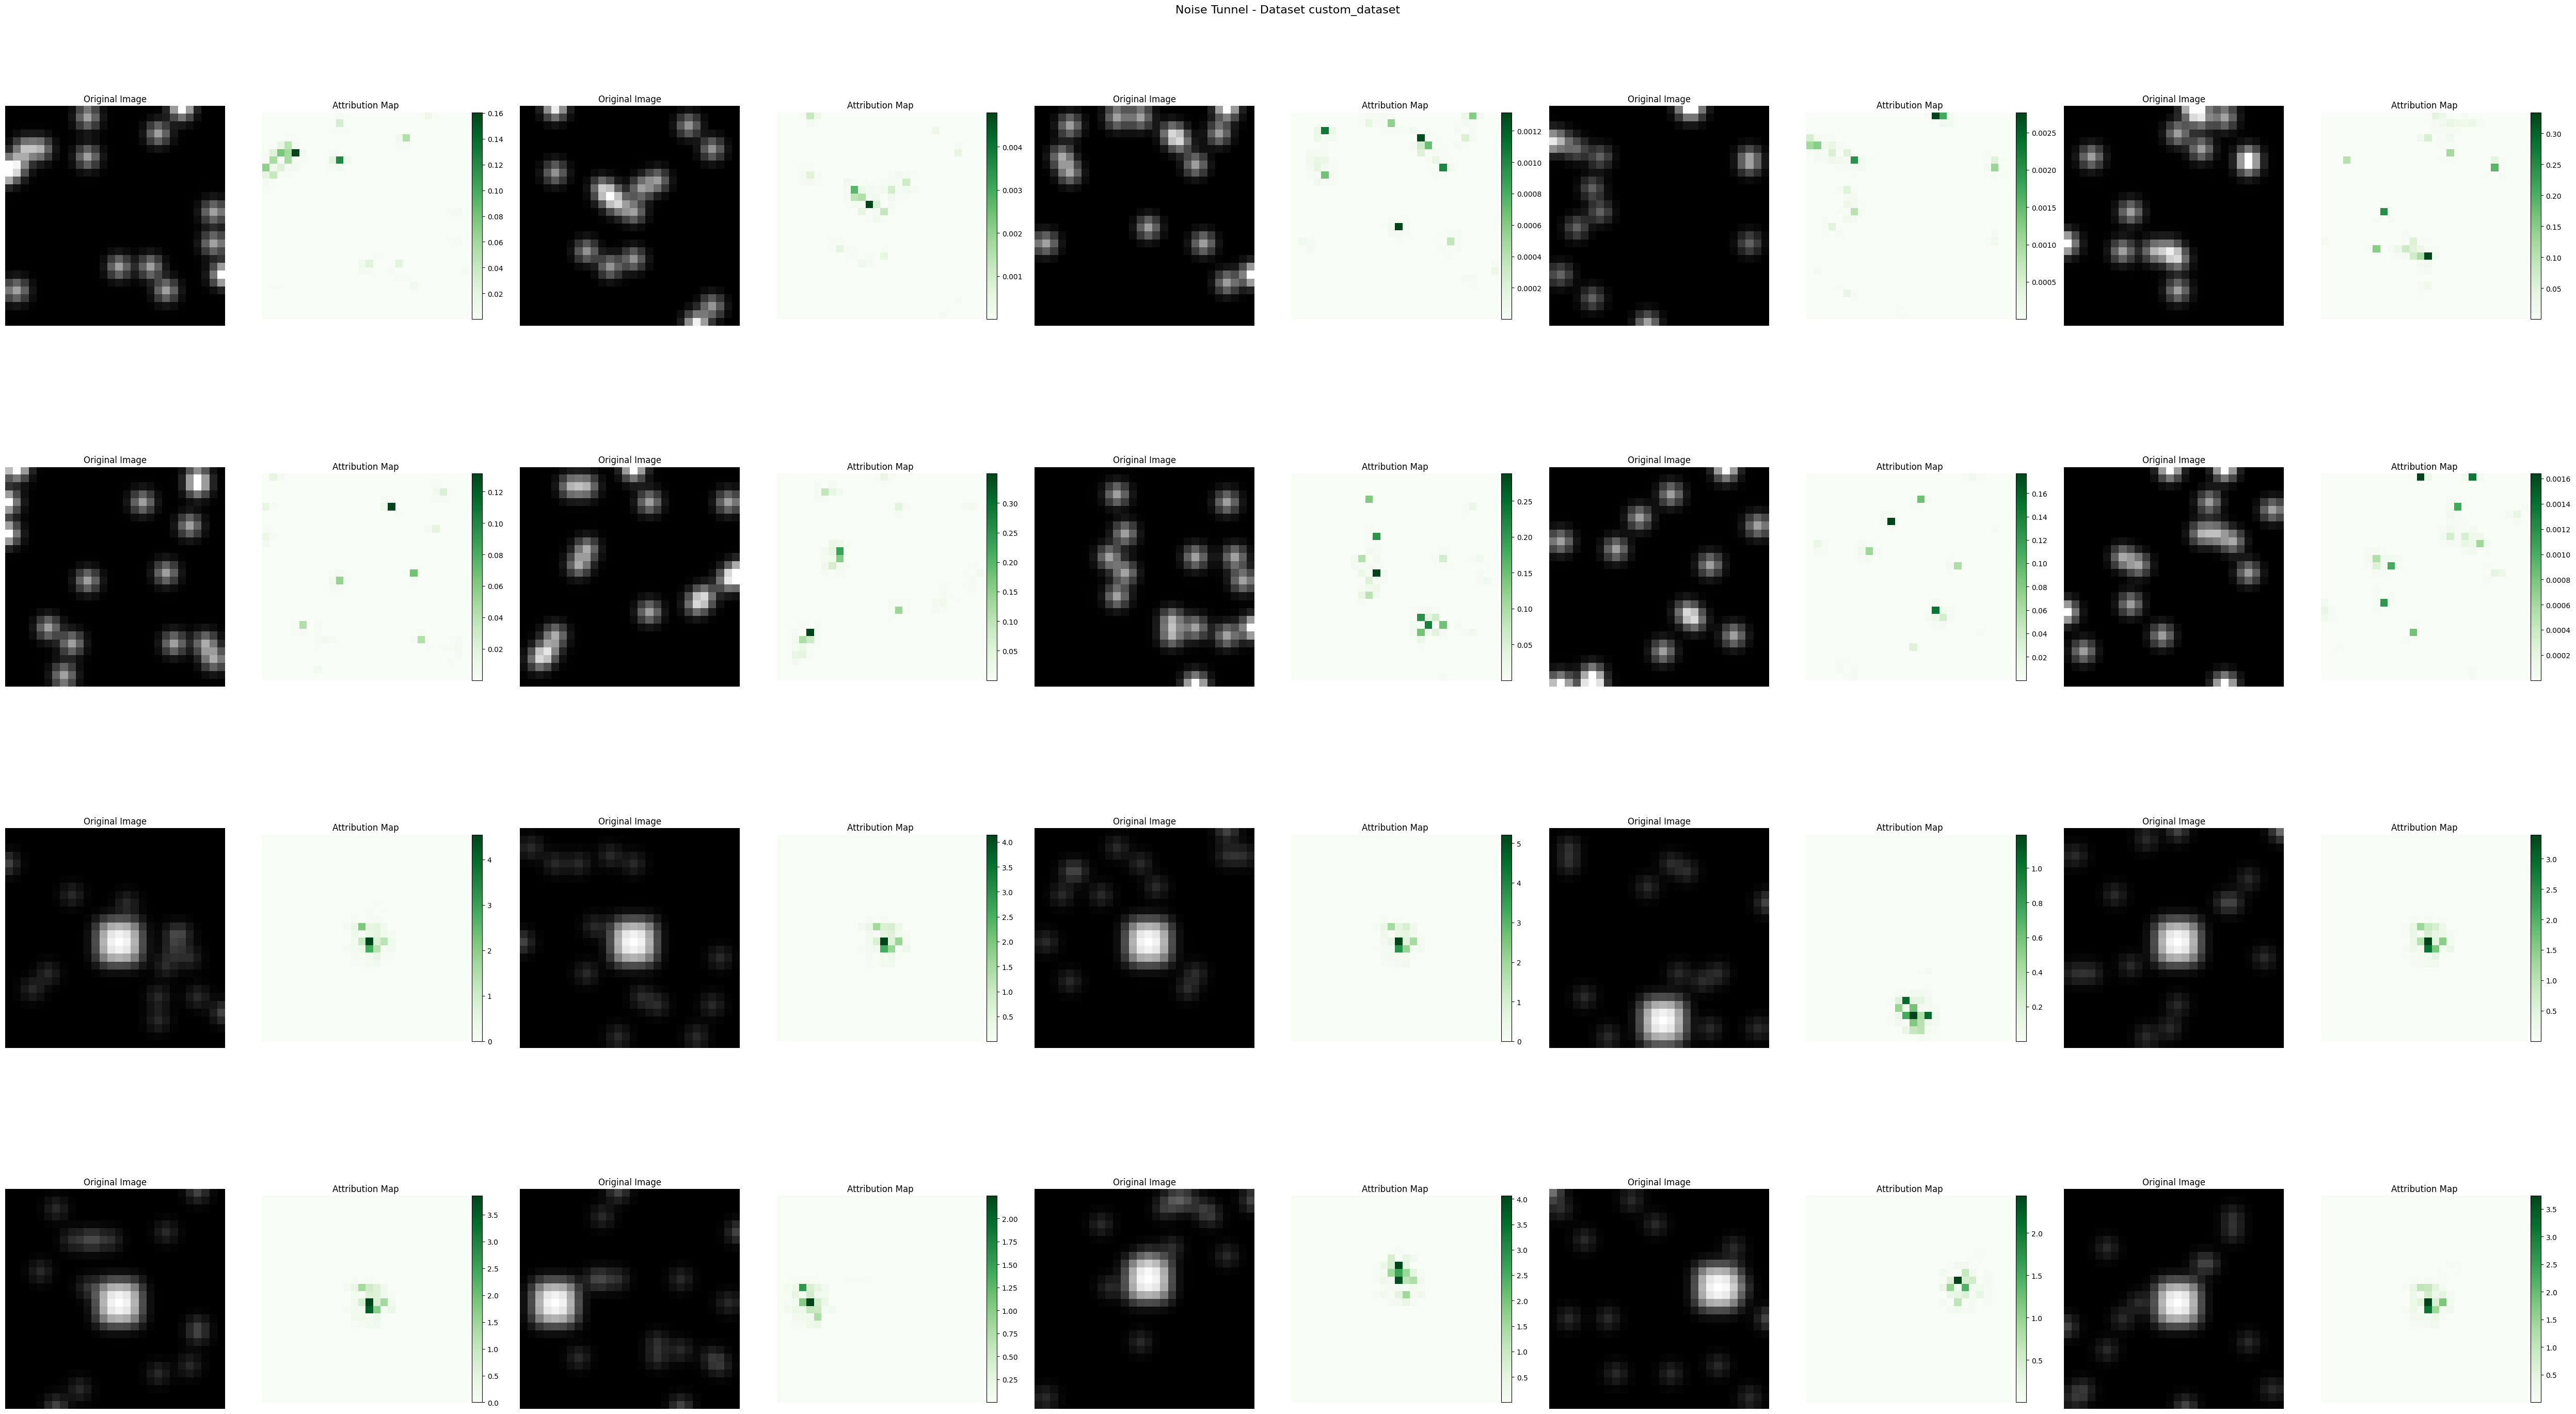

In [46]:
noise_tunnel = NoiseTunnel(integrated_gradients)
predicted_labels = [res["Predicted Label"] for res in results]

# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30)) # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Noise Tunnel - Dataset {dataset_type}', fontsize=16)

# Loop through each selected image
for idx, (image, predicted_label) in enumerate(zip(selected_images_list, predicted_labels)):
    
    # Generate attributions using NoiseTunnel with IntegratedGradients
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_ig_nt.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/noise_tunnel_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

/tmp/ipykernel_15275/3062322950.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3062322950.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3062322950.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3062322950.py:52: MatplotlibD

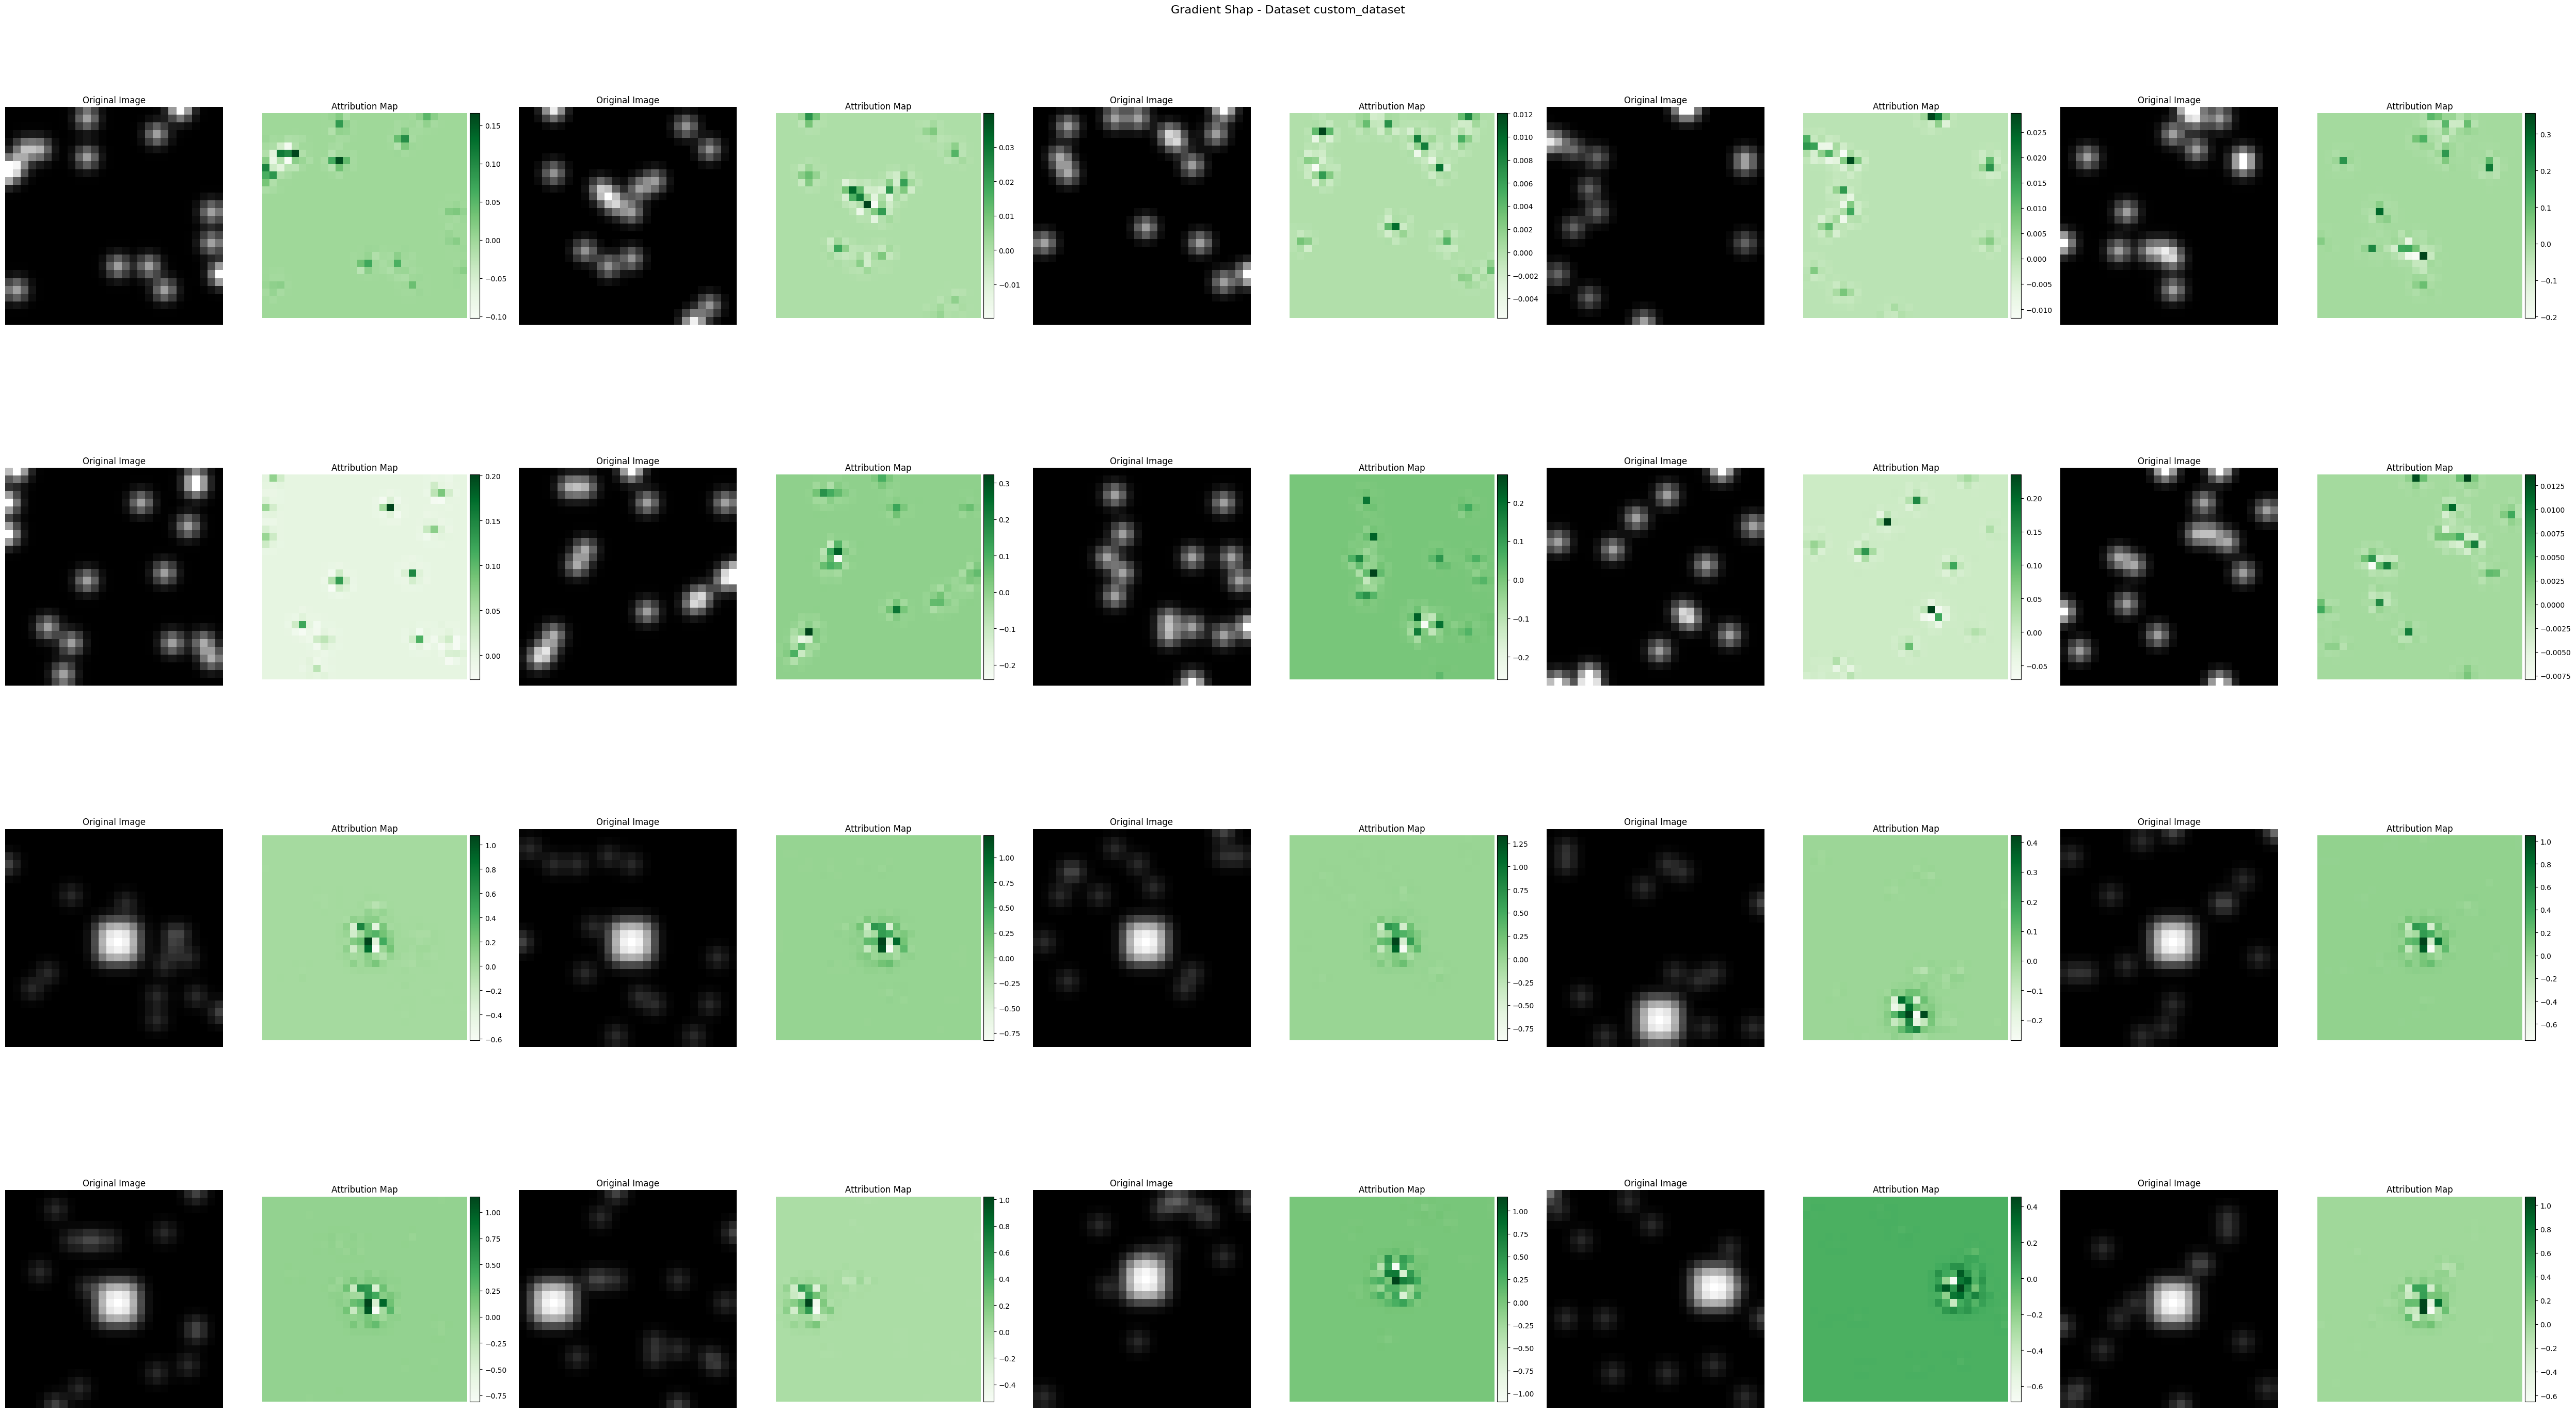

In [47]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Gradient Shap - Dataset {dataset_type}', fontsize=16)

gradient_shap = GradientShap(model)
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Loop through each selected image
for idx, (image, predicted_label) in enumerate(zip(selected_images_list, predicted_labels)):
    
    # Prepare the image for model
    input_img = image.unsqueeze(0)  # Add batch dimension
    
    # Defining baseline distribution of images for GradientShap
    rand_img_dist = torch.cat([input_img * 0, input_img * 1])
    
    # Generate attributions using GradientShap
    attributions_gs = gradient_shap.attribute(input_img,
                                              n_samples=50,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=predicted_label)
    
    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_gs.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()


/tmp/ipykernel_15275/3759676410.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3759676410.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3759676410.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15275/3759676410.py:44: MatplotlibDeprecationWa

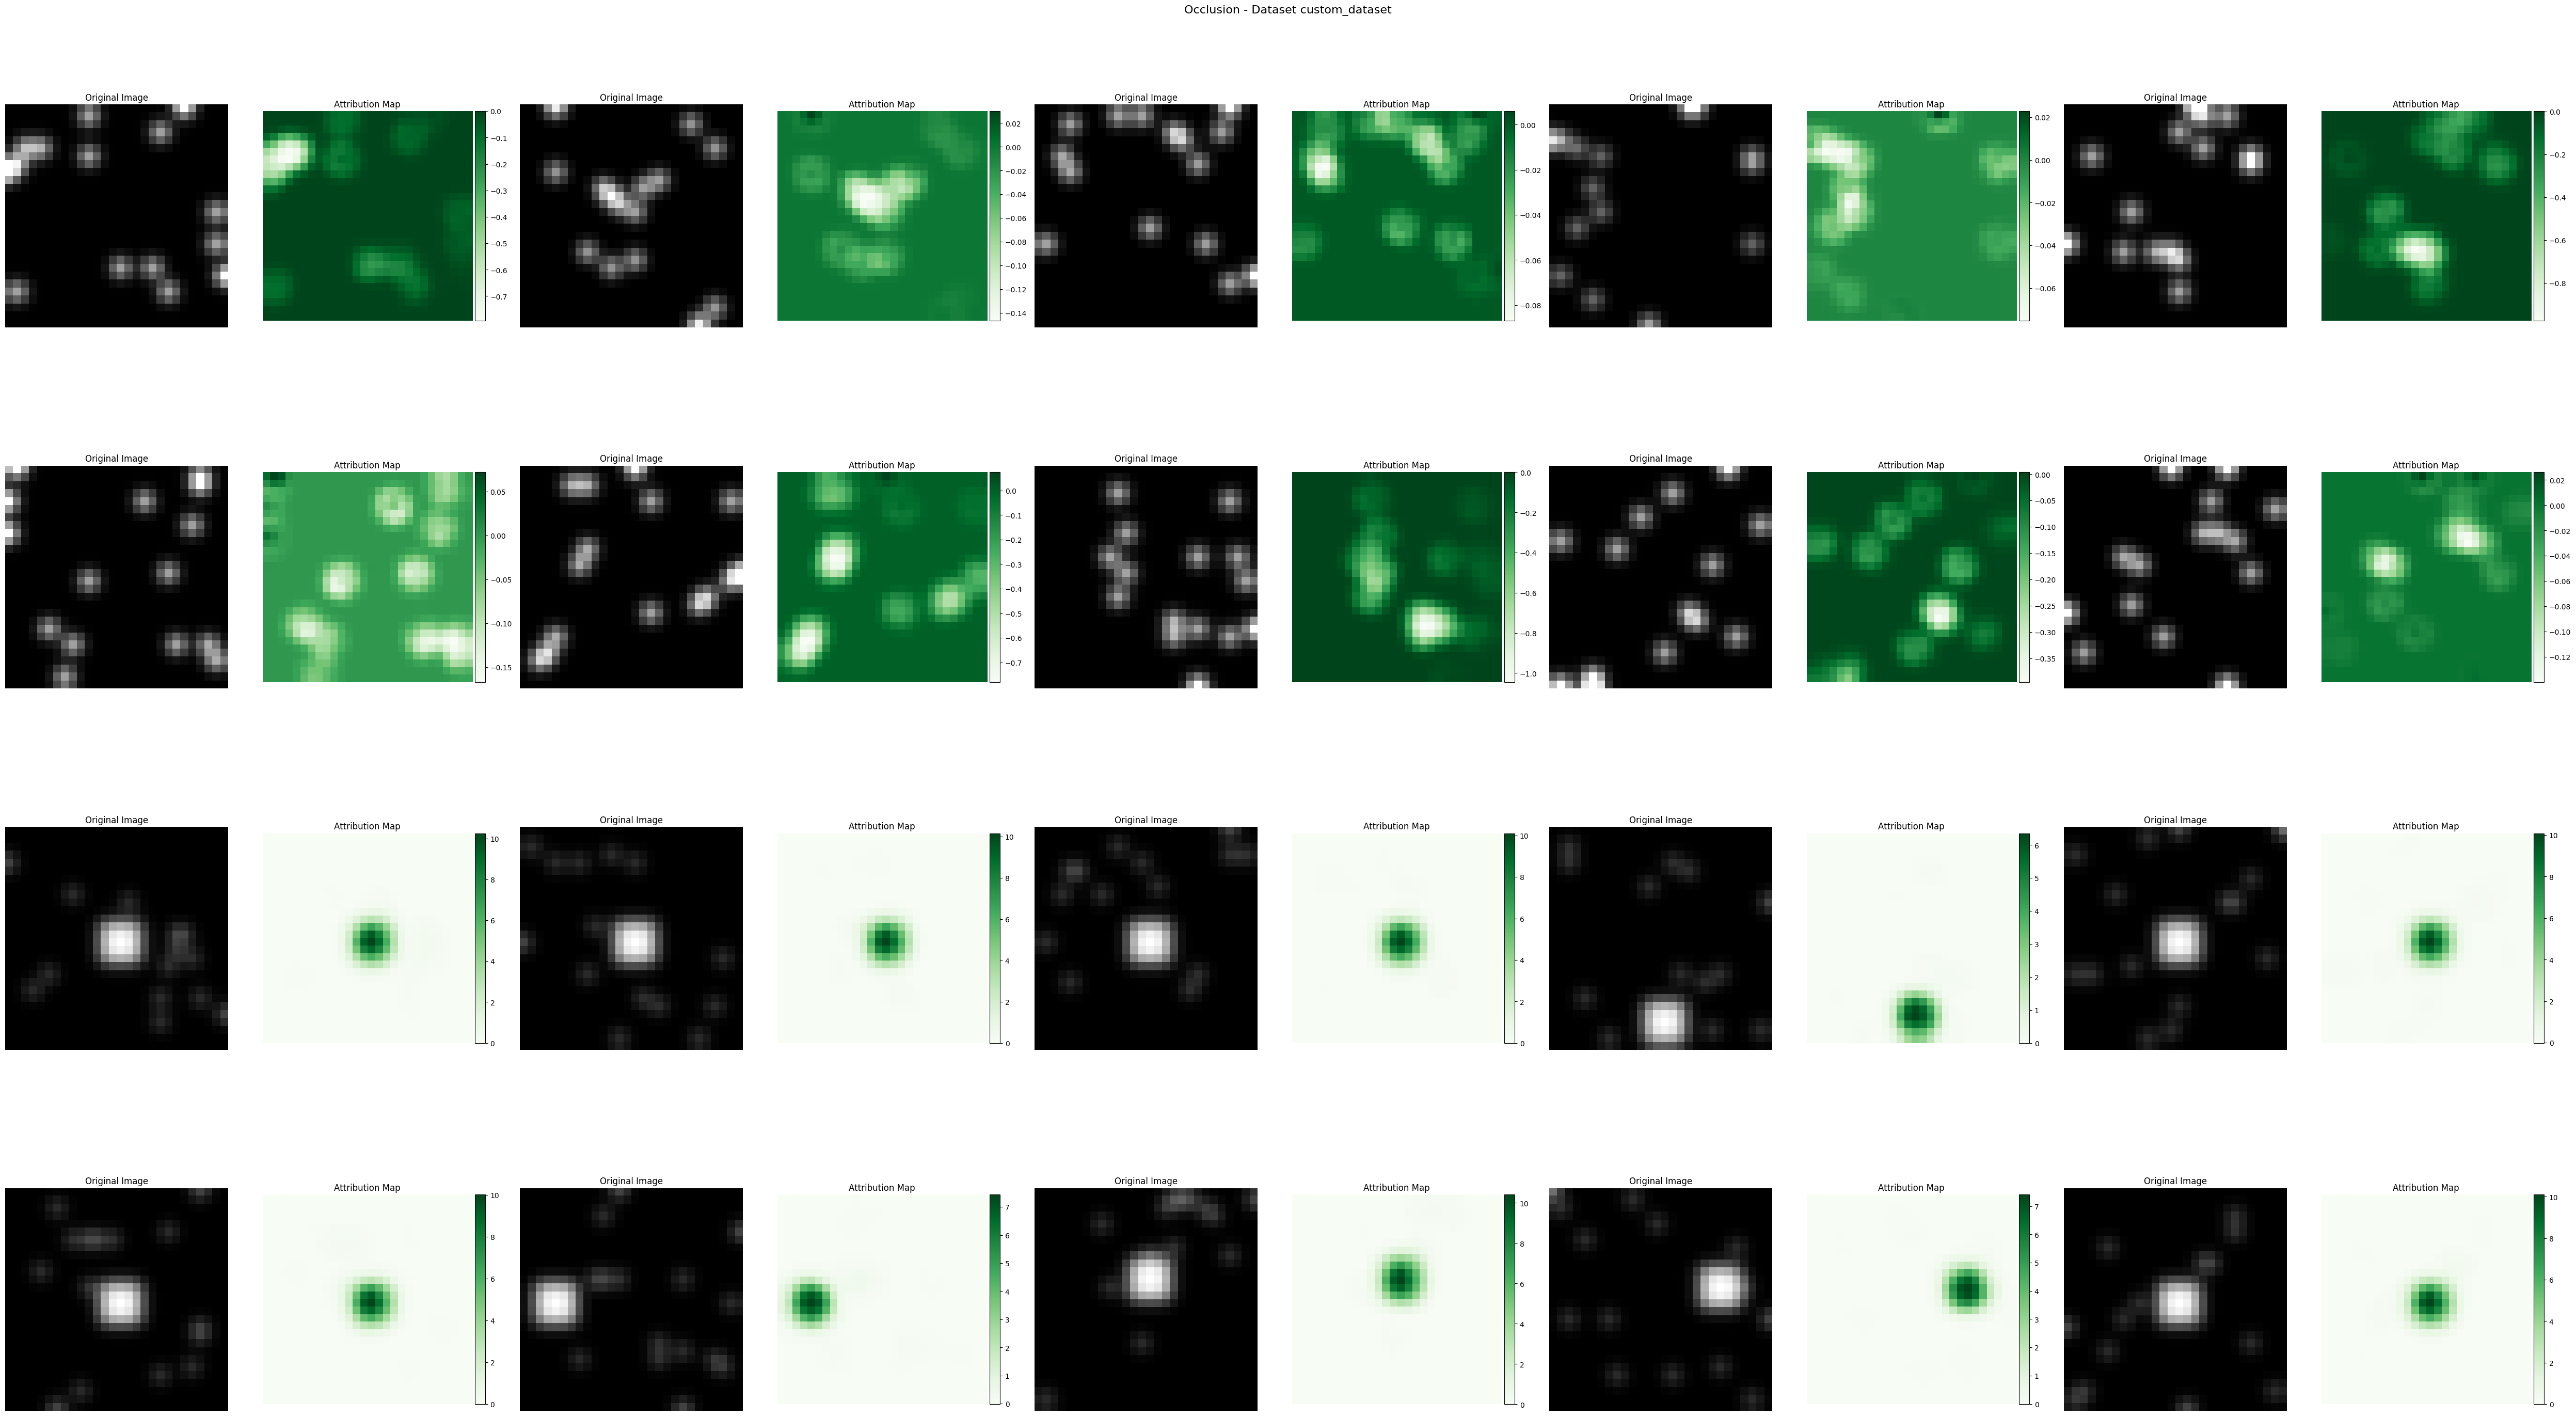

In [48]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Occlusion - Dataset {dataset_type}', fontsize=16)

occlusion = Occlusion(model)

# Loop through each selected image
for idx, (image, predicted_label) in enumerate(zip(selected_images_list, predicted_labels)):

    # Generate attributions using Occlusion
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_occ = occlusion.attribute(input_img,
                                           strides=(1, 1, 1),
                                           target=predicted_label,
                                           sliding_window_shapes=(1, 2, 2),
                                           baselines=0)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_occ.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()